### Libraries

In [1]:
import sys, os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import warnings

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from utils.EDA import vis_numeric_corr_matrix

In [2]:
load_dotenv()
warnings.filterwarnings("ignore")

# 한글 처리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 폰트 이름 얻어오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rcParams['font.family'] = font_name


### Load data

In [3]:
TRAIN_PATH = os.getenv('TRAIN_DATA_PATH')
TEST_PATH = os.getenv('TEST_DATA_PATH')

train = pd.read_csv(TRAIN_PATH).drop(columns=['ID'])
test = pd.read_csv(TEST_PATH).drop(columns=['ID'])
# vis_numeric_corr_matrix(train) #<--- for visualizing corr matrix
print(f"Column 일치 여부 : {train.columns.values.tolist()[:-1] == test.columns.values.tolist()}")
print(f"Train Row 수 :{len(train)}")
print(f"Test Row 수 :{len(test)}")
train.info()

Column 일치 여부 : True
Train Row 수 :256351
Test Row 수 :90067
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 68 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술 시기 코드               256351 non-null  object 
 1   시술 당시 나이               256351 non-null  object 
 2   임신 시도 또는 마지막 임신 경과 연수  9370 non-null    float64
 3   시술 유형                  256351 non-null  object 
 4   특정 시술 유형               256349 non-null  object 
 5   배란 자극 여부               256351 non-null  int64  
 6   배란 유도 유형               256351 non-null  object 
 7   단일 배아 이식 여부            250060 non-null  float64
 8   착상 전 유전 검사 사용 여부       2718 non-null    float64
 9   착상 전 유전 진단 사용 여부       250060 non-null  float64
 10  남성 주 불임 원인             256351 non-null  int64  
 11  남성 부 불임 원인             256351 non-null  int64  
 12  여성 주 불임 원인             256351 non-null  int64  
 13  여성 부 불임 원인             256351 n

In [4]:
# 결측 비율 80% 이상 제거
missing_ratio = train.isnull().mean()
column_missing = missing_ratio[missing_ratio >= 0.8].index.tolist()

# nunique = 1 제거 
unique_counts = train.nunique()
column_nunique = unique_counts[unique_counts == 1].index.tolist()

# 컬럼 제거
dropped_columns = list(set(column_missing + column_nunique))

train = train.drop(columns=dropped_columns)
test = test.drop(columns=dropped_columns)

print("제거된 컬럼 개수:", len(dropped_columns))
print("제거된 컬럼:", dropped_columns)
print("train.shape:", train.shape)
print("test.shape:", test.shape)

제거된 컬럼 개수: 8
제거된 컬럼: ['불임 원인 - 여성 요인', '착상 전 유전 검사 사용 여부', 'PGD 시술 여부', '배아 해동 경과일', 'PGS 시술 여부', '난자 해동 경과일', '난자 채취 경과일', '임신 시도 또는 마지막 임신 경과 연수']
train.shape: (256351, 60)
test.shape: (90067, 59)


### Preprocessing

In [5]:
from dotenv import load_dotenv
import os
load_dotenv()


import pandas as pd 
from sklearn.preprocessing import LabelEncoder

def get_feature(df, validation: bool):
    """
    Get the feature columns from the dataframe
    """
    columns_str = df.columns.to_list()
    
    if columns_str:
        columns_list = [col.strip() for col in columns_str.split(",")]
    
    # 임신 성공 여부 제거
    if validation:
        columns_list.remove('임신 성공 여부')

    return df[columns_list]

def preprocess(train:pd.DataFrame, validation = False):
    #%% SETTING
    le = LabelEncoder()
    
    #%% 시술 시기 코드
    train['시술 시기 코드'] = le.fit_transform(train['시술 시기 코드'])
    
    
    #%% 시술 당시 나이
    train['시술 당시 나이'] = train['시술 당시 나이'].map({
    '만18-34세': 0,
    '만35-37세': 1,
    '만38-39세': 2,
    '만40-42세': 3,
    '만43-44세': 4,
    '만45-50세': 5,
    '알 수 없음' : 999
    })
    
    #%% 임신 시도 또는 마지막 임신 경과 연수
    # train['임신 시도 또는 마지막 임신 경과 연수'] = train['임신 시도 또는 마지막 임신 경과 연수'].fillna(999)
    
    #%% 시술 유형
    train['시술 유형'] = le.fit_transform(train['시술 유형']) # Label Encoder

    train['특정 시술 유형'] = train['특정 시술 유형'].fillna('0')
    train['특정 시술 유형'] = le.fit_transform(train['특정 시술 유형'])
    
    #%% 배란 유도 유형
    # 배란 유도 유형에서 세트로타이드, 생식선 자극 호르몬 제거  -> 소수 데이터 sampling
    train = train[train['배란 유도 유형'] != '세트로타이드 (억제제)']
    train = train[train['배란 유도 유형'] != '생식선 자극 호르몬']

    # 기록되지 않은 시행 -> 1 / 알 수 없음 -> 0
    train['배란 유도 유형'] = train['배란 유도 유형'].map({
        '기록되지 않은 시행' : 1,
        '알 수 없음' : 0
    })

    #%% 단일 배아 이식 여부
    train['단일 배아 이식 여부'] = train['단일 배아 이식 여부'].fillna(0)
    
    #%% 착상 전 유전 검사 사용 여부
    # train['착상 전 유전 검사 사용 여부'] = train['착상 전 유전 검사 사용 여부'].fillna(0)
    
    #%% 착상 전 유전 진단 사용 여부
    train['착상 전 유전 진단 사용 여부'] = train['착상 전 유전 진단 사용 여부'].fillna(999) # -> 
    
    #%% 배아 생성 주요 이유
    train['배아 생성 주요 이유'] = train['배아 생성 주요 이유'].fillna('0')

    # train['배아 생성 주요 이유'] = train['배아 생성 주요 이유'].str.split(',')
    # train = train.explode('배아 생성 주요 이유') # 여러 행 분리 
    # train['배아 생성 주요 이유'] = train['배아 생성 주요 이유'].str.strip() # 좌우 공백 제거

    train['배아 생성 주요 이유'] = le.fit_transform(train['배아 생성 주요 이유'])
    
    #%% 총 시술 횟수
    train['총 시술 횟수'] = train['총 시술 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })

    #%% 클리닉 내 총 시술 횟수
    train['클리닉 내 총 시술 횟수'] = train['클리닉 내 총 시술 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    #%% IVF 시술 횟수
    train['IVF 시술 횟수'] = train['IVF 시술 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })

    #%% DI 시술 횟수
    train['DI 시술 횟수'] = train['DI 시술 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })

    #%% 총 임신 횟수
    train['총 임신 횟수'] = train['총 임신 횟수'].fillna('0회')
    train['총 임신 횟수'] = train['총 임신 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })

    #%% IVF 임신 횟수 
    train['IVF 임신 횟수'] = train['IVF 임신 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    #%% DI 임신 횟수
    train['DI 임신 횟수'] = train['DI 임신 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    #%% 총 출산 횟수
    train['총 출산 횟수'] = train['총 출산 횟수'].fillna('0회')
    train['총 출산 횟수'] = train['총 출산 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    
    #%% IVF 출산 횟수
    train['IVF 출산 횟수'] = train['IVF 출산 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    
    #%% DI 출산 횟수
    train['DI 출산 횟수'] = train['DI 출산 횟수'].map({
        '0회' : 0,
        '1회' : 1,
        '2회' : 2,
        '3회' : 3,
        '4회' : 4,
        '5회' : 5,
        '6회 이상' : 6,
    })
    
    #%% 총 생성 배아 수
    train['총 생성 배아 수'] = train['총 생성 배아 수'].fillna(999)

    #%% 미세주입된 난자 수 
    train['미세주입된 난자 수'] = train['미세주입된 난자 수'].fillna(999)
    
    #%% 미세주입에서 생성된 배아 수 
    train['미세주입에서 생성된 배아 수'] = train['미세주입에서 생성된 배아 수'].fillna(999)

    #%% 이식된 배아 수
    train['이식된 배아 수'] = train['이식된 배아 수'].fillna(999)

    #%% 이식된 배아 수
    train['저장된 배아 수'] = train['저장된 배아 수'].fillna(999)
    
    #%% 미세주입 배아 이식 수 
    train['미세주입 배아 이식 수'] = train['미세주입 배아 이식 수'].fillna(999)

    #%% 미세주입 후 저장된 배아 수 
    train['미세주입 후 저장된 배아 수'] = train['미세주입 후 저장된 배아 수'].fillna(999)

    #%% 혼합된 난자 수
    train['혼합된 난자 수'] = train['혼합된 난자 수'].fillna(999)

    #%% 파트너 정자와 혼합된 난자 수
    train['파트너 정자와 혼합된 난자 수'] = train['파트너 정자와 혼합된 난자 수'].fillna(999)
    
    #%% 기증자 정자와 혼합된 난자 수 -> 6291개는 제거하는게 좋을 것 같음
    # if not validation:
    #     train = train[train['기증자 정자와 혼합된 난자 수'].notnull()]
    
    #%% 난자정자 출처
    train['난자 출처'] = le.fit_transform(train['난자 출처'])
    train['정자 출처'] = le.fit_transform(train['정자 출처'])
    #%% 난자 기증자 나이
    train['난자 기증자 나이'] = train['난자 기증자 나이'].map({
        '알 수 없음' : 999,
        '만20세 이하' : 0,
        '만21-25세' : 1,
        '만26-30세' : 2,
        '만31-35세' : 3,
    })
    
    #%% 정자 기증자 나이
    train['정자 기증자 나이'] = train['정자 기증자 나이'].map({
        '알 수 없음' : 999,
        '만20세 이하' : 0,
        '만21-25세' : 1,
        '만26-30세' : 2,
        '만31-35세' : 3,
        '만36-40세' : 4,
        '만41-45세' : 5,
    })
    
    # %% 난자 채취 경과일
    # train['난자 채취 경과일'] = train['난자 채취 경과일'].fillna(999)
    
    #%% 동결 배아 사용 여부
    train['동결 배아 사용 여부'] = train['동결 배아 사용 여부'].fillna(999)
    
    #%% 신선 배아 사용 여부
    train['신선 배아 사용 여부'] = train['신선 배아 사용 여부'].fillna(999)

    #%% 난자 해동 경과일
    # train['난자 해동 경과일'] = train['난자 해동 경과일'].fillna(999)
    
    #%% 난자 혼합 경과일
    train['난자 혼합 경과일'] = train['난자 혼합 경과일'].fillna(999)
    
    #%% 배아 이식 경과일 
    train['배아 이식 경과일'] = train['배아 이식 경과일'].fillna(999)

    #%% 배아 해동 경과일 
    # train['배아 해동 경과일'] = train['배아 해동 경과일'].fillna(999)

    #%% 해동된 배아 수
    train['해동된 배아 수'] = train['해동된 배아 수'].fillna(999)

    #%% 해동된 난자 수
    train['해동 난자 수'] = train['해동 난자 수'].fillna(999)

    #%% 저장된 신선 난자 수
    train['저장된 신선 난자 수'] = train['저장된 신선 난자 수'].fillna(999)

    #%% 수집된 신선 난자 수
    train['수집된 신선 난자 수'] = train['수집된 신선 난자 수'].fillna(999)

    #%% 기증자 정자와 혼합된 난자 수
    train['기증자 정자와 혼합된 난자 수'] = train['기증자 정자와 혼합된 난자 수'].fillna(999)

    #%% 기증 배아 사용 여부
    train['기증 배아 사용 여부'] = train['기증 배아 사용 여부'].fillna(0)
    
    # #%% PGD 시술 여부 Nan -> 0으로 처리
    # train['PGD 시술 여부'] = train['PGD 시술 여부'].fillna(0)

    # #%% PGD 시술 여부 Nan -> 0으로 처리
    # train['PGS 시술 여부'] = train['PGS 시술 여부'].fillna(0)
    
    # #%% 대리모 여부 Nan -> 0으로 처리
    # train['대리모 여부'] = train['대리모 여부'].fillna(0)
    
    # 모두 0 처리
    # train = train.drop(columns = '불임 원인 - 여성 요인')
    
    
    
    #%% Column Selectㅅ
    # train = get_feature(train, validation)

    return train

In [6]:
pre_train = preprocess(train = train)
pre_test = preprocess(train = test, validation= True)

In [7]:
# 결측 비율 확인
pre_train.isnull().mean(), pre_test.isnull().mean()

(시술 시기 코드              0.000000
 시술 당시 나이              0.000000
 시술 유형                 0.000000
 특정 시술 유형              0.000000
 배란 자극 여부              0.000000
 배란 유도 유형              0.000000
 단일 배아 이식 여부           0.000000
 착상 전 유전 진단 사용 여부      0.000000
 남성 주 불임 원인            0.000000
 남성 부 불임 원인            0.000000
 여성 주 불임 원인            0.000000
 여성 부 불임 원인            0.000000
 부부 주 불임 원인            0.000000
 부부 부 불임 원인            0.000000
 불명확 불임 원인             0.000000
 불임 원인 - 난관 질환         0.000000
 불임 원인 - 남성 요인         0.000000
 불임 원인 - 배란 장애         0.000000
 불임 원인 - 자궁경부 문제       0.000000
 불임 원인 - 자궁내막증         0.000000
 불임 원인 - 정자 농도         0.000000
 불임 원인 - 정자 면역학적 요인    0.000000
 불임 원인 - 정자 운동성        0.000000
 불임 원인 - 정자 형태         0.000000
 배아 생성 주요 이유           0.000000
 총 시술 횟수               0.000000
 클리닉 내 총 시술 횟수         0.000000
 IVF 시술 횟수             0.000000
 DI 시술 횟수              0.000000
 총 임신 횟수               0.000000
 IVF 임신 횟수             0.000000
 DI 임신 횟

### Feature engineering

In [10]:
import pandas as pd

def feature_engineering(df):

    # -------------------------
    # 1. 시술 정보 관련 변수
    # -------------------------
    # 기본 정보
    # df['나이 대비 임신 확률'] = df['총 임신 횟수'] / df['시술 당시 나이']
    # df['나이 대비 임신 시도 기간'] = df['임신 시도 또는 마지막 임신 경과 연수'] / df['시술 당시 나이']

    # 시술 횟수 관련 변수
    # df['총 임신 성공률'] = df['총 임신 횟수'] / df['총 시술 횟수']
    # df['IVF 임신 성공률'] = df['IVF 임신 횟수'] / df['IVF 시술 횟수']
    # df['시술당 평균 배아 생성 수'] = df['총 생성 배아 수'] / df['총 시술 횟수']
    # df['시술당 평균 이식 배아 수'] = df['이식된 배아 수'] / df['총 시술 횟수']
    df['시술 경험 점수'] = (df['총 시술 횟수'] + df['클리닉 내 총 시술 횟수']) / 2

    # -------------------------
    # 2. 임신 및 출산 정보 관련 변수
    # -------------------------
    # 임신 관련
    # df['임신 시도 대비 성공률'] = df['총 임신 횟수'] / (df['임신 시도 또는 마지막 임신 경과 연수'] + 1e-6)
    
    # 출산 관련
    # df['총 출산 성공률'] = df['총 출산 횟수'] / df['총 임신 횟수']
    df['IVF 출산 성공률'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1e-6)
    df['출산 유지율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1e-6)
    # df['출산-임신 성공률 차이'] = df['총 출산 성공률'] - df['총 임신 성공률']

    # -------------------------
    # 3. 배아 관련 정보 변수
    # -------------------------
    # 배아 생성 정보
    df['미세주입 배아 생성 확률'] = df['미세주입에서 생성된 배아 수'] / (df['미세주입된 난자 수'] + 1e-6)

    # 배아 이식 정보
    df['배아 이식 대비 최종 출산 성공률'] = df['총 출산 횟수'] / (df['이식된 배아 수'] + 1e-6)
    df['총 배아 이식 확률'] = df['이식된 배아 수'] / (df['총 생성 배아 수'] + 1e-6)
    df['미세주입 배아 이식 확률'] = df['미세주입 배아 이식 수'] / (df['미세주입에서 생성된 배아 수'] + 1e-6)
    
    # 배아 저장 및 해동 정보
    df['저장된 배아 사용률'] = df['이식된 배아 수'] / (df['저장된 배아 수'] + 1e-6)
    df['해동 배아 사용률'] = df['해동된 배아 수'] / (df['저장된 배아 수'] + 1e-6)
    df["배아 저장 대비 이식 기간"] = df["배아 이식 경과일"] / (df["저장된 배아 수"] + 1e-6)

    # -------------------------
    # 4. 난자 관련 정보 변수
    # -------------------------
    # 난자 수집 및 해동 정보
    df['난자 채취 대비 배아 생성 기간'] = df['배아 이식 경과일'] / (df['수집된 신선 난자 수'] + 1e-6)
    df['난자 혼합 비율'] = df['혼합된 난자 수'] / (df['수집된 신선 난자 수'] + 1e-6)

    # -------------------------
    # 5. 불임 원인 정보 변수
    # -------------------------
    # 불임 원인 다양성: 여러 불임 원인이 True인 개수

    # (추가 예시) 자궁내막증, 자궁경부 문제 등 여성 불임 세부 요인 점수
    # 해당 컬럼들이 존재한다고 가정
    if '불임 원인 - 자궁내막증' in df.columns and '불임 원인 - 자궁경부 문제' in df.columns:
        df['여성 불임 세부 지표'] = (
            df['불임 원인 - 자궁내막증'] * 1 +  # 가중치는 임의
            df['불임 원인 - 자궁경부 문제'] * 1
        )

    # (추가 예시) 정자 상태에 대한 세부 요인 점수
    # 해당 컬럼들이 존재한다고 가정
    if '불임 원인 - 정자 농도' in df.columns and '불임 원인 - 정자 운동성' in df.columns and '불임 원인 - 정자 형태' in df.columns:
        df['남성 정자 종합 지표'] = (
            df['불임 원인 - 정자 농도'] +
            df['불임 원인 - 정자 운동성'] +
            df['불임 원인 - 정자 형태']
            # 필요 시 각각에 다른 가중치 부여 가능
        )

    # -------------------------
    # 6. 기타 정보 변수
    # -------------------------

    # 착상 전 유전 검사/진단(PGS/PGD) 사용 여부 (True/False라고 가정)
    # 예: 사용하면 1, 아니면 0
    if '착상 전 유전 검사 사용 여부' in df.columns:
        df['PGS 사용'] = df['착상 전 유전 검사 사용 여부'].astype(int)
    if '착상 전 유전 진단 사용 여부' in df.columns:
        df['PGD 사용'] = df['착상 전 유전 진단 사용 여부'].astype(int)

    # -------------------------
    # 7. 배란 관련 정보
    # -------------------------

    # 배란 유도 유형이 범주형이라면 one-hot 인코딩 혹은 단순 라벨 인코딩
    if '배란 유도 유형' in df.columns:
        df = pd.get_dummies(df, columns=['배란 유도 유형'], prefix='배란유도')

    # -------------------------
    # 8. 시간 경과 관련 변수
    # -------------------------
    # df['난자 채취-이식 경과 비율'] = df['배아 이식 경과일'] / (df['난자 채취 경과일'] + 1e-6)
    # df['배아 해동 이후 이식 기간'] = df['배아 이식 경과일'] - df['배아 해동 경과일']

    return df

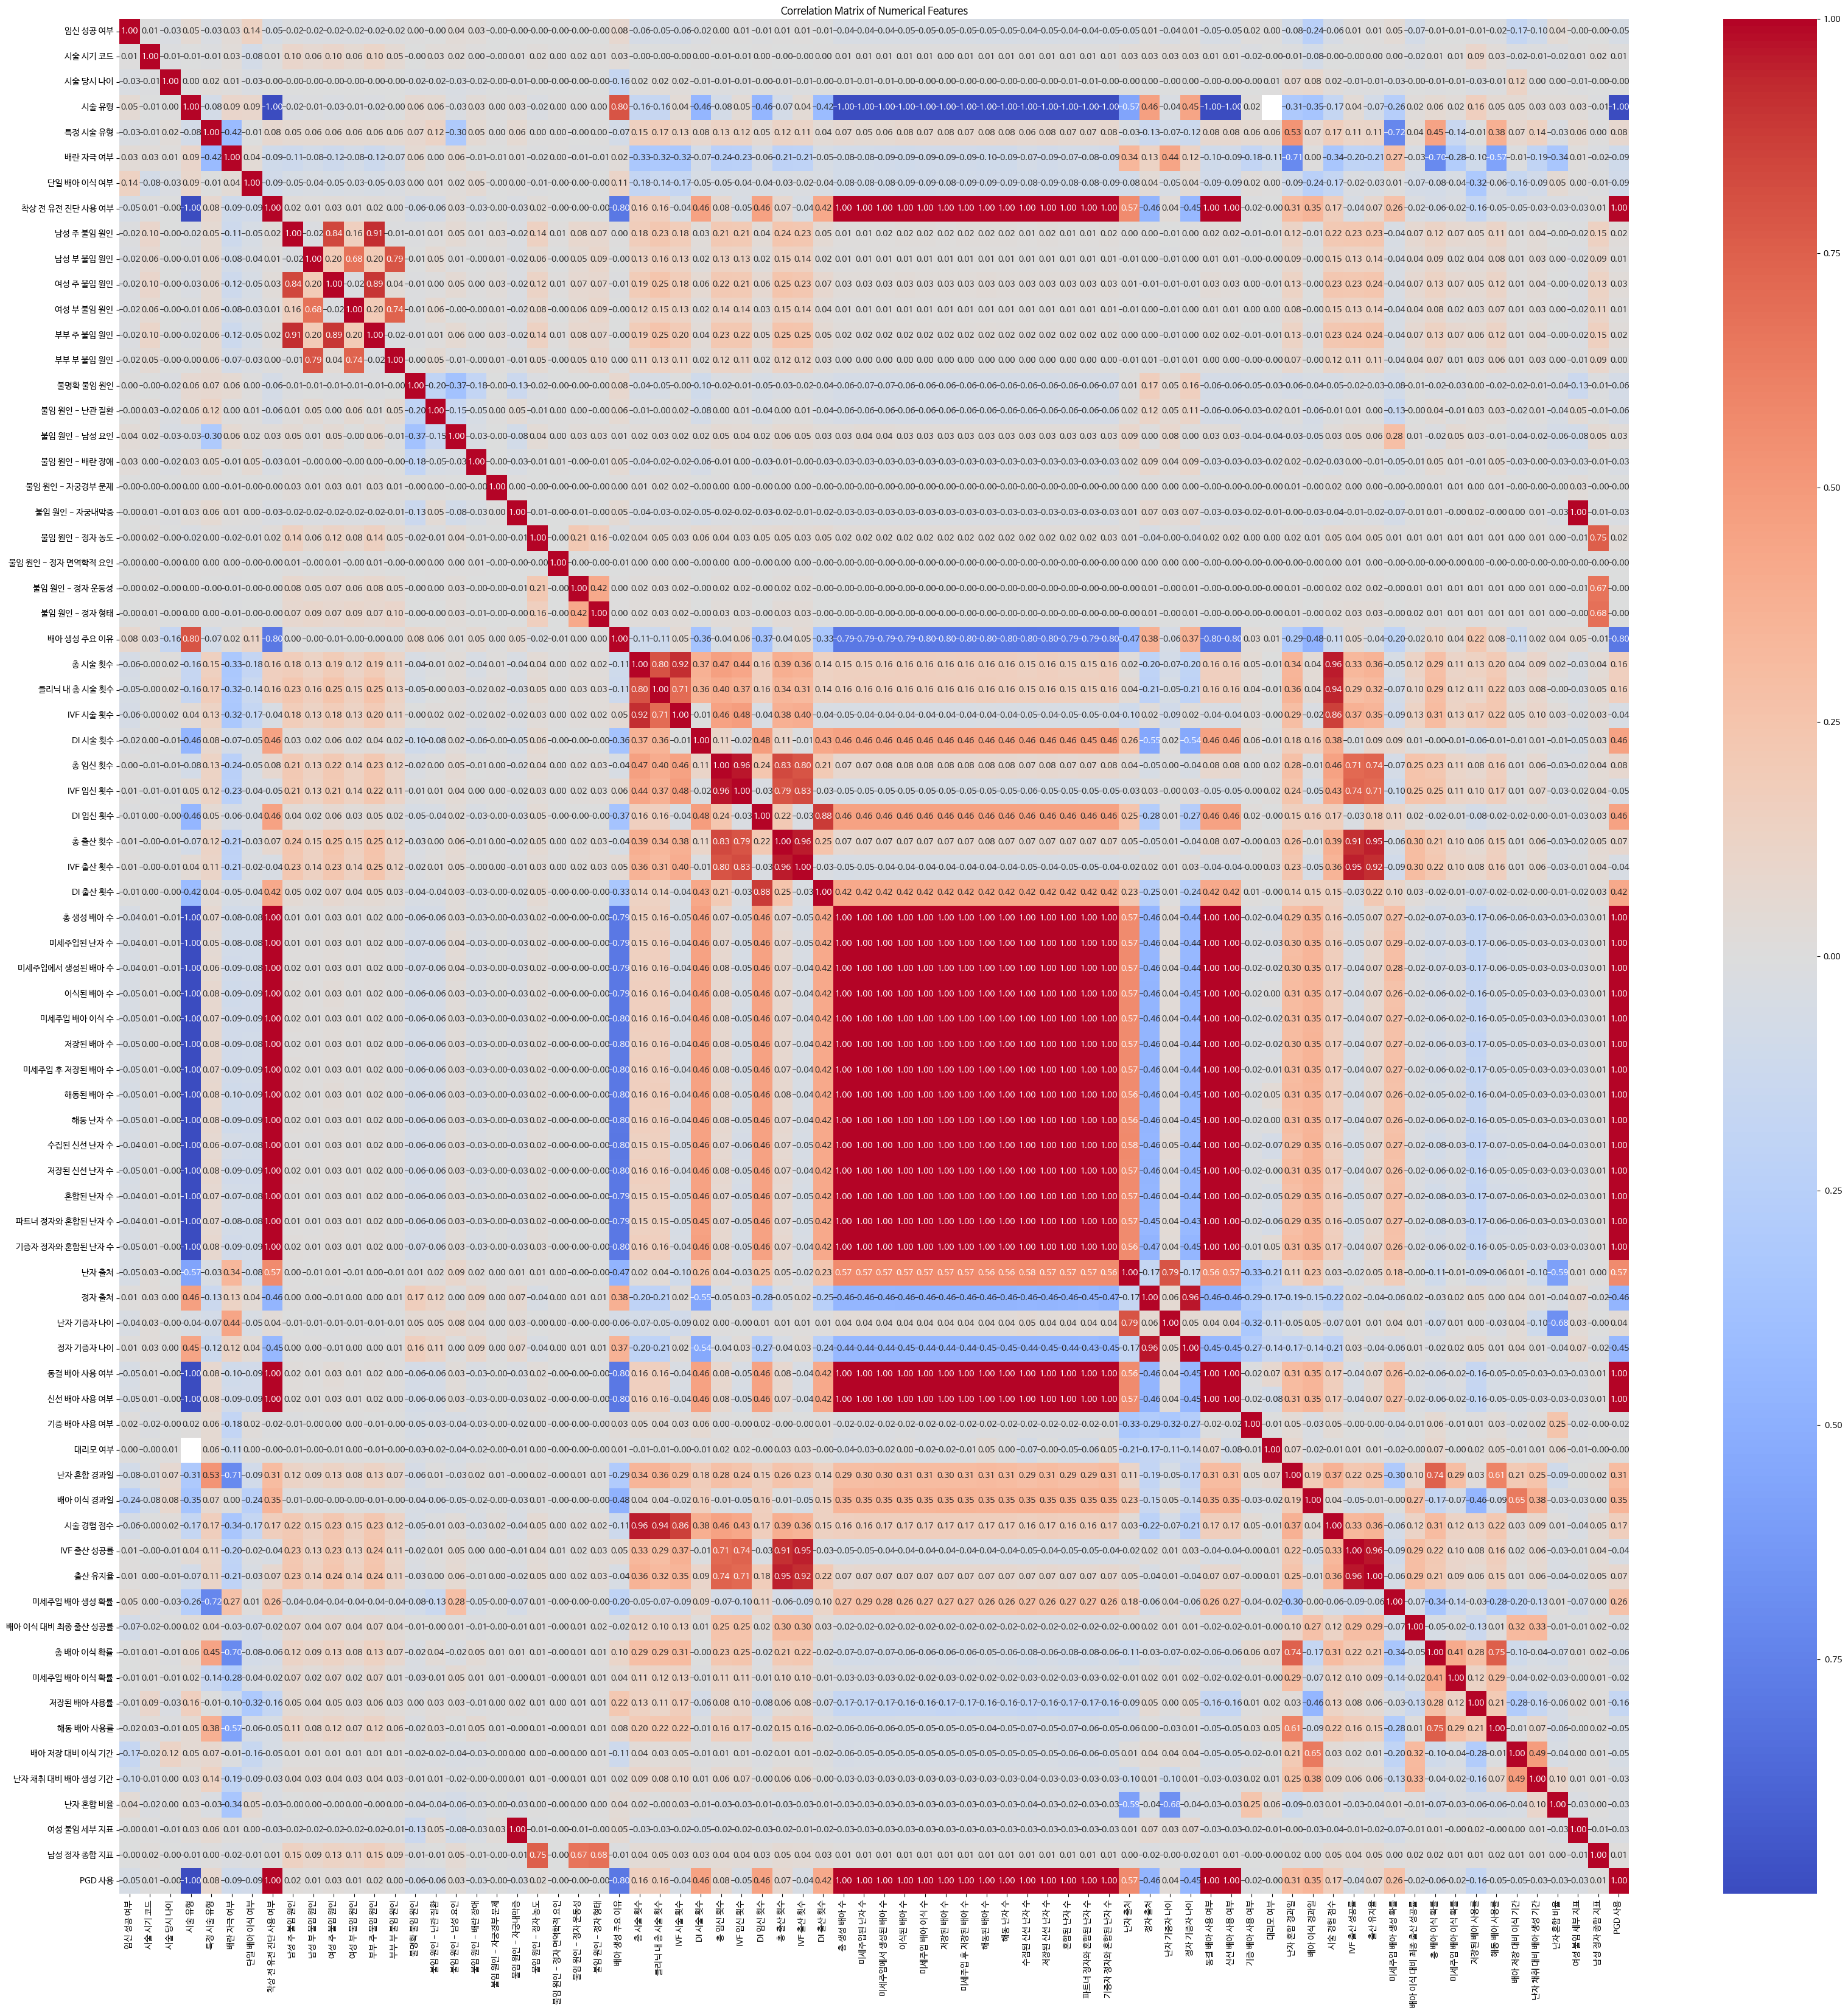

In [11]:
df_train = feature_engineering(pre_train)
df_test = feature_engineering(pre_test)


vis_numeric_corr_matrix(df_train)


In [12]:
# 결측 비율
missing_ratio = df_train.isnull().mean() * 100
print(missing_ratio)

시술 시기 코드       0.0
시술 당시 나이       0.0
시술 유형          0.0
특정 시술 유형       0.0
배란 자극 여부       0.0
              ... 
여성 불임 세부 지표    0.0
남성 정자 종합 지표    0.0
PGD 사용         0.0
배란유도_0         0.0
배란유도_1         0.0
Length: 76, dtype: float64


In [13]:
train['대리모 여부'].value_counts()

대리모 여부
0.0    249011
1.0      1049
Name: count, dtype: int64

In [14]:
# Nan Inf Detect
from utils.EDA import find_inf_nan_columns

find_inf_nan_columns(df_train)

{'inf_col': ['대리모 여부'], 'nan_col': ['대리모 여부']}

In [15]:
# NaN 값이 있는 행
df_train[df_train.isna().any(axis=1)]

,시술 시기 코드,시술 당시 나이,시술 유형,특정 시술 유형,배란 자극 여부,단일 배아 이식 여부,착상 전 유전 진단 사용 여부,남성 주 불임 원인,남성 부 불임 원인,여성 주 불임 원인,...,저장된 배아 사용률,해동 배아 사용률,배아 저장 대비 이식 기간,난자 채취 대비 배아 생성 기간,난자 혼합 비율,여성 불임 세부 지표,남성 정자 종합 지표,PGD 사용,배란유도_0,배란유도_1
14,4,2,0,15,0,0.0,999.0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,0,0,999,True,False
39,1,0,0,15,1,0.0,999.0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,0,0,999,True,False
127,2,1,0,15,1,0.0,999.0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,0,0,999,True,False
162,4,2,0,15,1,0.0,999.0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,0,0,999,True,False
174,0,3,0,15,0,0.0,999.0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,0,0,999,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256174,6,5,0,15,1,0.0,999.0,0,0,1,...,1.0,1.0,1.0,1.0,1.0,0,0,999,True,False
256222,5,0,0,15,1,0.0,999.0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1,0,999,True,False
256228,5,3,0,15,1,0.0,999.0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,0,0,999,True,False
256301,0,3,0,15,0,0.0,999.0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,0,0,999,True,False


### Feature selection

In [16]:
# object 타입 컬럼 확인
cat_features = list(df_train.select_dtypes(include=['object']).columns)
cat_features

[]

### Modeling

In [17]:
X = df_train.drop('임신 성공 여부', axis=1)
y = df_train['임신 성공 여부']

#### 일반

In [18]:
# Data split 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=123)
X_test = df_test

print('X_train.shape:', X_train.shape)
print('X_val.shape:', X_val.shape)
print('y_train.shape:', y_train.shape)
print('y_val.shape:', y_val.shape)
print('X_test.shape:', X_test.shape)

X_train.shape: (205079, 75)
X_val.shape: (51270, 75)
y_train.shape: (205079,)
y_val.shape: (51270,)
X_test.shape: (90067, 75)


In [19]:
from utils.metric import print_evaluation_metrics, evaluate_model

# # 모델 정의
cat_model = CatBoostClassifier(
    iterations=700, learning_rate=0.03, depth=8, l2_leaf_reg=10,
    subsample=0.8, colsample_bylevel=0.8, random_strength=10,
    loss_function='Logloss', eval_metric='AUC', verbose=100
)

xgb_model = XGBClassifier(
    n_estimators=700, learning_rate=0.03, max_depth=7, min_child_weight=3,
    gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
    reg_lambda=1.0, verbosity=1
)

lgbm_model = LGBMClassifier(
    n_estimators=700, learning_rate=0.03, max_depth=-1, num_leaves=64,
    min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=1.0, verbosity=1
)

ensemble_model = VotingClassifier(
    estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model)],
    voting='soft', weights=[1, 1, 1]
)

# # 모델 학습
# cat_model.fit(X_train, y_train)
# xgb_model.fit(X_train, y_train)
# lgbm_model.fit(X_train, y_train)
# ensemble_model.fit(X_train, y_train)


# print("------ CatBoost ------")
# print_evaluation_metrics(cat_model, y_val, X_val)
# print("------ XGBoost ------")
# print_evaluation_metrics(xgb_model, y_val, X_val)
# print("------ LightGBM ------")
# print_evaluation_metrics(lgbm_model, y_val, X_val)
# print("------ Ensemble ------ ")
# print_evaluation_metrics(ensemble_model, y_val, X_val)

#### Stratified K-Fold 

In [20]:
X = df_train.drop('임신 성공 여부', axis=1)
y = df_train['임신 성공 여부']

In [21]:
# Stratified K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

metrics = {model: [] for model in ['CatBoost']}

k_fold_models = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"===== Fold {fold} =====")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # # 모델 정의
    # k_fold_model = CatBoostClassifier(
    #     iterations=700, learning_rate=0.03, depth=8, l2_leaf_reg=10,
    #     subsample=0.8, colsample_bylevel=0.8, random_strength=10,
    #     loss_function='Logloss', eval_metric='AUC', verbose=100
    # )
    k_fold_model = VotingClassifier(
        estimators=[('catboost', cat_model), ('xgboost', xgb_model), ('lightgbm', lgbm_model)],
        voting='soft', weights=[1, 1, 1]
    )
    
    # 모델 학습
    for model in [k_fold_model]:
        model.fit(X_train, y_train)
    
    k_fold_models.append(model)
    
    # 평가
    for model_name, model in zip(metrics.keys(), [k_fold_model]):
        metrics[model_name].append(evaluate_model(model, X_val, y_val))

for model_name, model_metrics in metrics.items():
    avg_metrics = {metric: np.mean([fold_metric[metric] for fold_metric in model_metrics]) for metric in model_metrics[0]}
    
    print(f"\n== {model_name} Model ==")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")
metrics

===== Fold 1 =====
0:	total: 75.1ms	remaining: 52.5s
100:	total: 1.13s	remaining: 6.68s
200:	total: 2.26s	remaining: 5.61s
300:	total: 3.48s	remaining: 4.61s
400:	total: 4.58s	remaining: 3.42s
500:	total: 5.76s	remaining: 2.29s
600:	total: 7s	remaining: 1.15s
699:	total: 8.23s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 52982, number of negative: 152097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 205079, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258349 -> initscore=-1.054566
[LightGBM] [Info] Start training from score -1.054566
===== Fold 2 =====
0:	total: 16.7ms	remaining: 11.7s
100:	total: 1.

{'CatBoost': [{'Accuracy': 0.7461478447435147,
   'Precision': 0.5383077948034644,
   'Recall': 0.12200830502076256,
   'F1 Score': 0.19892903305225582,
   'ROC AUC Score': 0.7394005036820613},
  {'Accuracy': 0.7454456797347376,
   'Precision': 0.5343484419263456,
   'Recall': 0.11392978482446206,
   'F1 Score': 0.18781504760719397,
   'ROC AUC Score': 0.7403570200904463},
  {'Accuracy': 0.745504193485469,
   'Precision': 0.5318532818532818,
   'Recall': 0.12479239015551864,
   'F1 Score': 0.20215237862296684,
   'ROC AUC Score': 0.7358111548881021},
  {'Accuracy': 0.7474741564267603,
   'Precision': 0.5499165275459098,
   'Recall': 0.12433942322210478,
   'F1 Score': 0.20282002339757405,
   'ROC AUC Score': 0.7421691711337284},
  {'Accuracy': 0.7446020012093078,
   'Precision': 0.5247622171203673,
   'Recall': 0.120800302000755,
   'F1 Score': 0.1963913096845465,
   'ROC AUC Score': 0.7382785391070883}]}

### Prediction

In [ ]:
def mean_ID_extract(df:pd.DataFrame):
    df['probability'] = df.groupby('ID')['probability'].transform('mean')
    df_unique = df.drop_duplicates(subset=['ID'], keep='first').reset_index(drop=True)
    return df_unique

def max_ID_extract(df:pd.DataFrame):
    df['probability'] = df.groupby('ID')['probability'].transform('max')
    df_unique = df.drop_duplicates(subset=['ID'], keep='first').reset_index(drop=True)
    return df_unique

# counts = df_test['ID'].value_counts()
# repeated_ids = counts[counts > 1].index  # 2번 이상 등장하는 ID만 뽑아냄

# # 인덱스 목록으로 필터링하여, 해당 ID를 가진 행만 추출
# df_repeated = df_test[df_test['ID'].isin(repeated_ids)]
# df_repeated

# df_mean = mean_ID_extract(df_repeated)
# df_mean

# df_max = max_ID_extract(df_repeated)
# df_max

# (df_mean['probability'] == df_max['probability']).value_counts()

In [ ]:
from utils.EDA import vis_prob_barchart
# 평가 지표 평균 출력
for idx, model in enumerate(k_fold_models):
    # df_test를 수정하지 않고, drop(columns='ID')만 해서 사용
    pred_proba = model.predict_proba(df_test.drop(columns='ID'))[:, 1]
    
    # df_test에 probability 컬럼을 만들지 않고, 바로 max_ID_extract에 넣을 임시 DF를 만듦
    temp_df = df_test[['ID']].copy()
    temp_df['probability'] = pred_proba
    
    pred_proba_max = max_ID_extract(temp_df)['probability']
    test[f'probability_{idx+1}'] = pred_proba_max

# test에 probability_1 ~ probability_5 컬럼이 있을 때
pred_main_proba = test[[
    'probability_1',
    'probability_2',
    'probability_3',
    'probability_4',
    'probability_5'
]].mean(axis=1)

pred_main_proba

### Submission

In [ ]:
df_test

In [ ]:
SUBMISSION_DATA_PATH = os.getenv('SUBMISSION_DATA_PATH')
sample_submission = pd.read_csv(SUBMISSION_DATA_PATH)
sample_submission['probability'] = pred_main_proba
# 저장
import datetime 
now = datetime.datetime.now()
save_path = os.path.join(f'./log/submission/{now.strftime("%Y%m%d_%H%M%S")}.csv')
print(f"save path : {save_path}")
sample_submission.to_csv(save_path, index=False)
sample_submission.head()

In [ ]:
# 확인용
submission = pd.read_csv(save_path)

In [ ]:
submission
